<a href="https://colab.research.google.com/github/rayanecardozo/machine-learning-studies/blob/main/03_Clusterizacao_Absenteismo_no_trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Absenteísmo no trabalho
Problema de classificação!!

Dados obtidos faz parte da pesquisa acadêmica na Universidade Nove de Julho

Período: 07/2007-07/2010

Conjunto de dados:

- 19/21 características
- 740 registros

### Características:

1-ID,

2-Reason for absence,

3-Month of absence,

4-Day of the week: (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6)),

5-Seasons: (summer (1), autumn (2), winter (3), spring (4)),

6-Transportation expense,

7-Distance from Residence to Work: (kilometers),

8-Service time,

9-Age,  

10-Hit target,

11-Disciplinary failure: (yes=1; no=0),

12-Education: (high school (1), graduate (2), postgraduate (3), master and doctor (4)),

13-Son: (number of children),

14-Social drinker: (yes=1; no=0),

15-Social smoker: (yes=1; no=0),

16-Pet: (number of pet),

17-Weight,

18-Height,

19-Body mass index,

20-Work load Average/day,

21-Absenteeism time in hours (target)

PARTE **I**

PRÉ-PROCESSAMENTO

In [ ]:
#Importação de bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, silhouette_samples

In [ ]:
#Leitura do arquivo
#Arquivo extraído do site https://archive.ics.uci.edu/datasets?Task=Clustering&skip=0&take=10&sort=desc&orderBy=NumHits&search=
df = pd.read_csv('data.csv', sep=';')
df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


<Axes: >

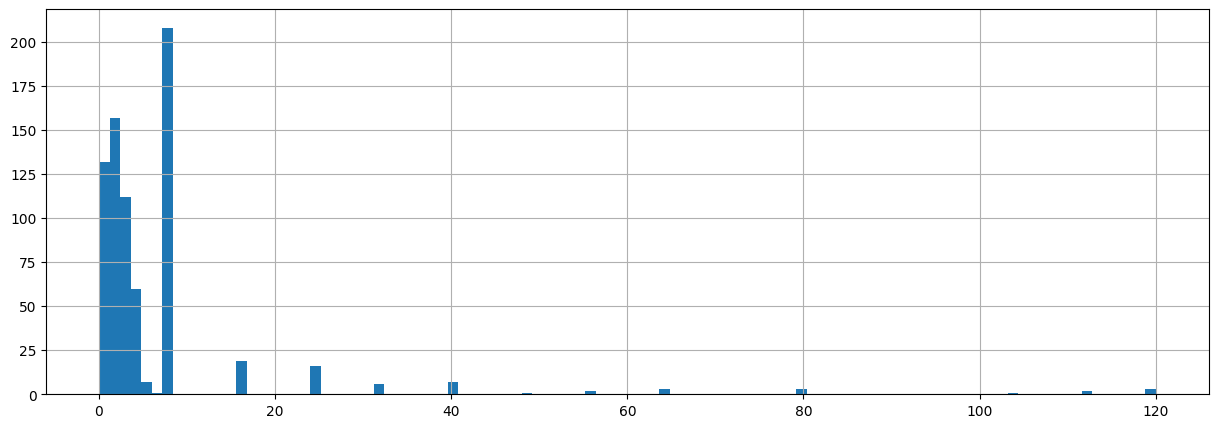

In [ ]:
df['Absenteeism time in hours'].hist(bins=100, figsize=(15, 5))

In [ ]:
# Separa zeros de não zeros
zeros = df[df['Absenteeism time in hours'] == 0].copy()
non_zeros = df[df['Absenteeism time in hours'] != 0].copy()

# Separação quantil para não zeros
non_zeros['Absenteeism_Category'] = pd.qcut(non_zeros['Absenteeism time in hours'], q=3, labels=['Baixa ausência', 'Média ausência', 'Alta ausência'])

# Atribui classe 0 para zeros
zeros['Absenteeism_Category'] = 'Sem ausência'

# Combina exemplos
df = pd.concat([zeros, non_zeros]).sort_index()

# Resultado
print(df['Absenteeism_Category'].value_counts())


Absenteeism_Category
Média ausência    388
Baixa ausência    245
Alta ausência      63
Sem ausência       44
Name: count, dtype: int64


In [ ]:
# Ver proporção das novas classes
print(df['Absenteeism_Category'].value_counts(normalize=True) * 100)
# Sem ausência
# Baixa ausência (1–8h)
# Média ausência (9–24h)
# Alta ausência (acima de 24h)
df

Absenteeism_Category
Média ausência    52.432432
Baixa ausência    33.108108
Alta ausência      8.513514
Sem ausência       5.945946
Name: proportion, dtype: float64


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,Absenteeism_Category
0,11,26,7,3,1,289,36,13,33,239.554,...,1,2,1,0,1,90,172,30,4,Média ausência
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,0,0,98,178,31,0,Sem ausência
2,3,23,7,4,1,179,51,18,38,239.554,...,1,0,1,0,0,89,170,31,2,Baixa ausência
3,7,7,7,5,1,279,5,14,39,239.554,...,1,2,1,1,0,68,168,24,4,Média ausência
4,11,23,7,5,1,289,36,13,33,239.554,...,1,2,1,0,1,90,172,30,2,Baixa ausência
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,11,14,7,3,1,289,36,13,33,264.604,...,1,2,1,0,1,90,172,30,8,Média ausência
736,1,11,7,3,1,235,11,14,37,264.604,...,3,1,0,0,1,88,172,29,4,Média ausência
737,4,0,0,3,1,118,14,13,40,271.219,...,1,1,1,0,8,98,170,34,0,Sem ausência
738,8,0,0,4,2,231,35,14,39,271.219,...,1,2,1,0,2,100,170,35,0,Sem ausência


In [ ]:
#Verificação de dados faltantes
df.isnull().sum()

,0
ID,0
Reason for absence,0
Month of absence,0
Day of the week,0
Seasons,0
Transportation expense,0
Distance from Residence to Work,0
Service time,0
Age,0
Work load Average/day,0


In [ ]:
# Remover ID e variável alvo
df = df.drop(columns=["ID", "Absenteeism time in hours"])

In [ ]:
#Verificação dos tipos de dados
df.dtypes

,0
Reason for absence,int64
Month of absence,int64
Day of the week,int64
Seasons,int64
Transportation expense,int64
Distance from Residence to Work,int64
Service time,int64
Age,int64
Work load Average/day,float64
Hit target,int64


In [ ]:
df.describe()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027
std,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452
min,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000
25%,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000
50%,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000
75%,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000
max,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000


In [ ]:
# Remoção de outliers com Z-Score

# Selecionar apenas as colunas numéricas
df_numerico = df.select_dtypes(include=['int64', 'float64'])

# Calcular z-score apenas nas colunas numéricas
z_scores = np.abs(stats.zscore(df_numerico))

# Definir o limiar
limiar = 4

# Filtrar o DataFrame com base nos z-scores
df_sem_outliers = df[(z_scores < limiar).all(axis=1)]

# Visualizar o novo shape
print("Shape sem outliers:", df_sem_outliers.shape)

Shape sem outliers: (688, 20)


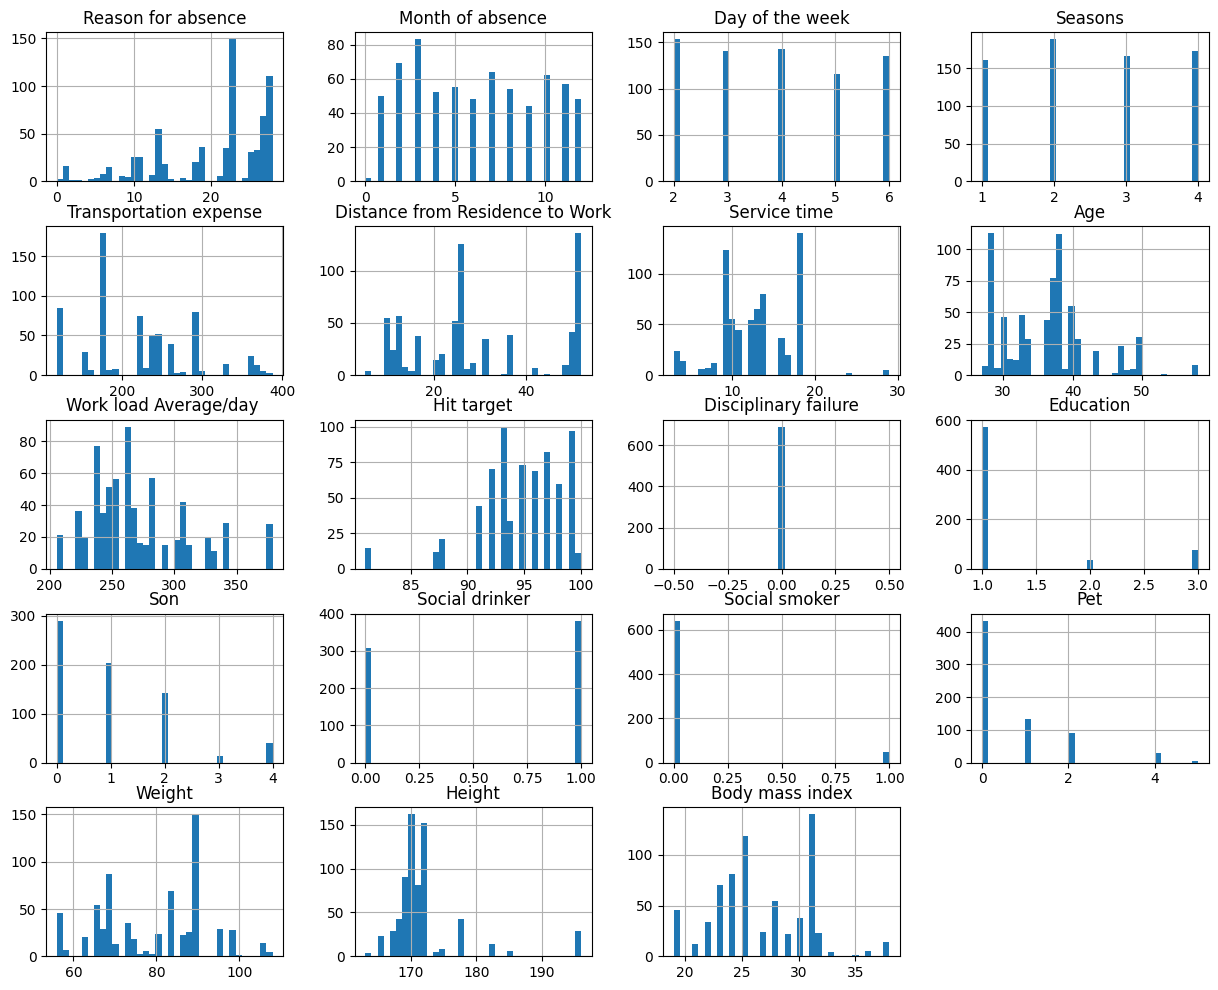

In [ ]:
#Analisando a distribuição com histogramas de cada característica
df_sem_outliers.hist(figsize=(15, 12), bins=35)
plt.show()

In [ ]:
#                                         Normalização após remoção dos outliers
# Selecionar apenas as colunas numéricas para normalização
colunas_numericas = df_sem_outliers.select_dtypes(include=['int64', 'float64']).columns

# Normalizar os dados numéricos
scaler = StandardScaler()
X_normalized_numerico = pd.DataFrame(scaler.fit_transform(df_sem_outliers[colunas_numericas]),
                                     columns=colunas_numericas,
                                     index=df_sem_outliers.index)

# Juntar as colunas não numéricas com as colunas normalizadas
colunas_nao_numericas = df_sem_outliers.drop(columns=colunas_numericas)
X_normalized = pd.concat([X_normalized_numerico, colunas_nao_numericas], axis=1)

# Verificar resultado
print(X_normalized.head())

   Reason for absence  Month of absence  Day of the week   Seasons  \
0            0.776348          0.214161        -0.638047 -1.366785   
2            0.363576          0.214161         0.062075 -1.366785   
3           -1.837878          0.214161         0.762197 -1.366785   
4            0.363576          0.214161         0.762197 -1.366785   
5            0.363576          0.214161         1.462319 -1.366785   

   Transportation expense  Distance from Residence to Work  Service time  \
0                1.048023                         0.424947      0.079692   
2               -0.612211                         1.440804      1.241299   
3                0.897092                        -1.674490      0.312013   
4                1.048023                         0.424947      0.079692   
5               -0.612211                         1.440804      1.241299   

        Age  Work load Average/day   Hit target  Disciplinary failure  \
0 -0.516039               -0.810704    0.633162  

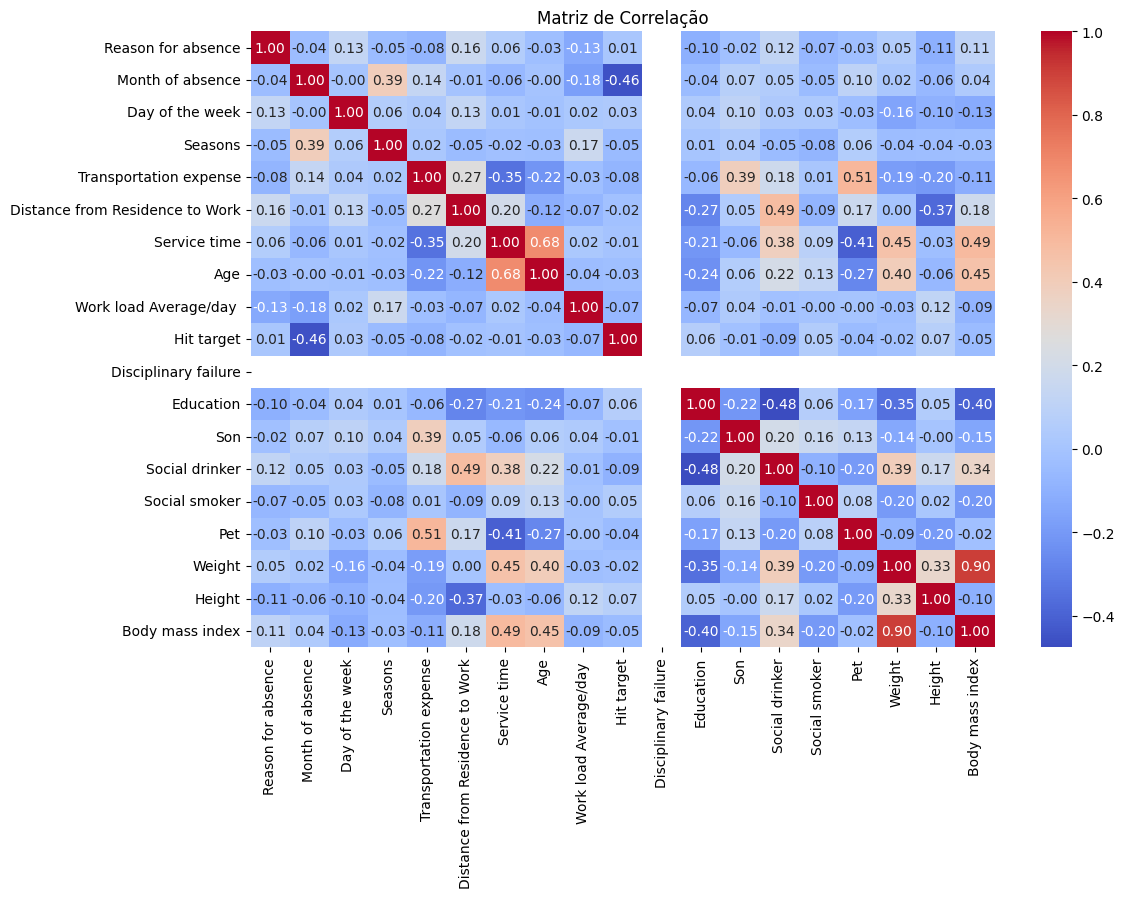

In [ ]:
# Análise de correlação entre variáveis
df_numerico = df_sem_outliers.select_dtypes(include=['int64', 'float64'])

# Análise de correlação entre variáveis
plt.figure(figsize=(12, 8))
sns.heatmap(df_numerico.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlação")
plt.show()

## Testes Iniciais com Clusterização - K-Means, DBSCAN e Agrupamento Hierárquico

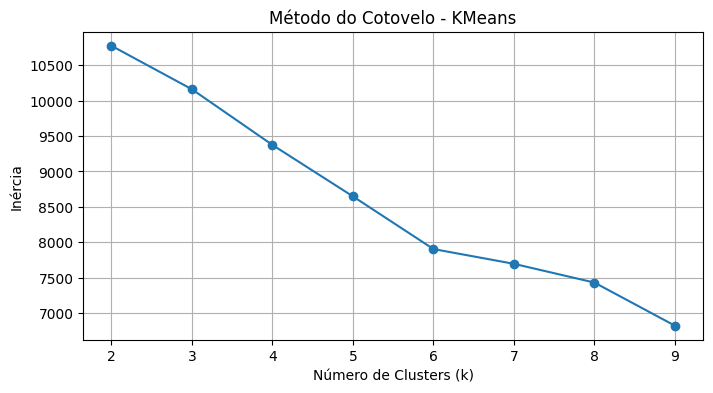


Silhouette Score - KMeans: 0.1987


In [ ]:
# Determinar melhor número de clusters para K-Means usando método do cotovelo
# Remover colunas não numéricas se ainda existirem em X_normalized
X_kmeans = X_normalized.select_dtypes(include=['float64', 'int64'])

# Método do cotovelo
inertias = []
range_k = range(2, 10)

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_kmeans)
    inertias.append(kmeans.inertia_)

# Gráfico do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(range_k, inertias, marker='o')
plt.title('Método do Cotovelo - KMeans')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.grid(True)
plt.show()

# Treinando com melhor k
melhor_k = 9
kmeans = KMeans(n_clusters=melhor_k, random_state=42)
X_normalized['Cluster_KMeans'] = kmeans.fit_predict(X_kmeans)

# Avaliação com Silhouette Score
score_kmeans = silhouette_score(X_kmeans, X_normalized['Cluster_KMeans'])
print(f"\nSilhouette Score - KMeans: {score_kmeans:.4f}")

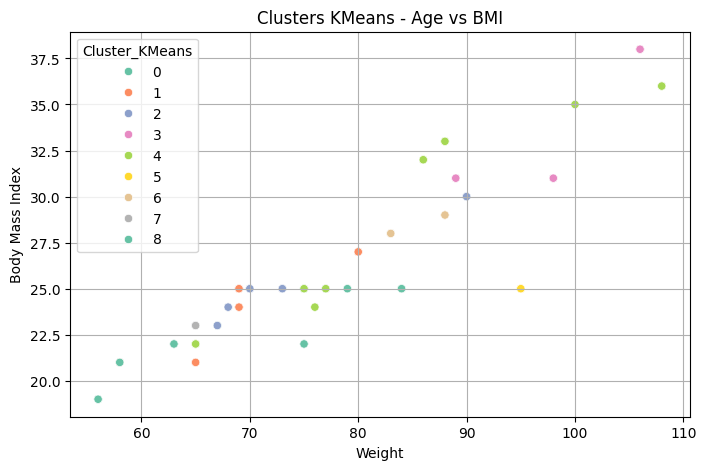

In [ ]:
# Visualização da distribuição dos clusters (exemplo com K-Means)
# Recolocar os rótulos dos clusters no dataset original normalizado
X_normalized['Weight'] = df['Weight']
X_normalized['BMI'] = df['Body mass index']

plt.figure(figsize=(8, 5))
sns.scatterplot(data=X_normalized, x='Weight', y='BMI', hue='Cluster_KMeans', palette='Set2')
plt.title('Clusters KMeans - Age vs BMI')
plt.xlabel('Weight')
plt.ylabel('Body Mass Index')
plt.grid(True)
plt.show()

Discussão:

O algoritmo K-Means apresentou um Silhouette Score de 0.19 com a escolha de 9 clusters, a partir do gráfico de cotovelo.
Embora o número de grupos gerados permita uma segmentação mais detalhada dos dados, a qualidade da separação entre os clusters foi relativamente baixa. Isso sugere que os grupos podem estar sobrepostos ou que o número de clusters foi superestimado. Como o K-Means assume que os clusters são esféricos e de mesma densidade, sua aplicação pode ser limitada em dados mais complexos ou com outliers (porem estes foram removidos).

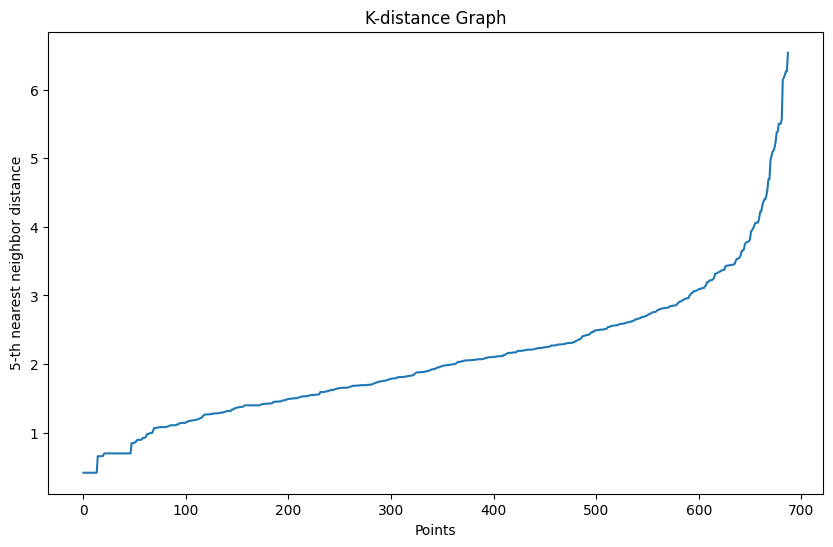

In [ ]:
# No caso do DBSCAN, não usamos gráfico de cotovelo como fazemos com o KMeans. Descobri-se com base na densidade dos dados.
# Seleciona apenas colunas numéricas para o DBSCAN
X_dbscan = X_normalized.select_dtypes(include=['float64', 'int64'])

from sklearn.neighbors import NearestNeighbors

# Function to plot k-distance graph
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.show()
# Plot k-distance graph
plot_k_distance_graph(X_dbscan, k=5)

In [ ]:
# Aplica o DBSCAN
dbscan = DBSCAN(eps=6, min_samples=2*len(df.columns))
X_normalized['Cluster_DBSCAN'] = dbscan.fit_predict(X_dbscan)

# Avaliação
labels_dbscan = X_normalized['Cluster_DBSCAN']
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)

if n_clusters_dbscan > 1:
    score_dbscan = silhouette_score(X_dbscan, labels_dbscan)
    print(f"Silhouette Score - DBSCAN: {score_dbscan:.4f}")
else:
    print("DBSCAN formou menos de 2 clusters válidos.")

Silhouette Score - DBSCAN: 0.3224


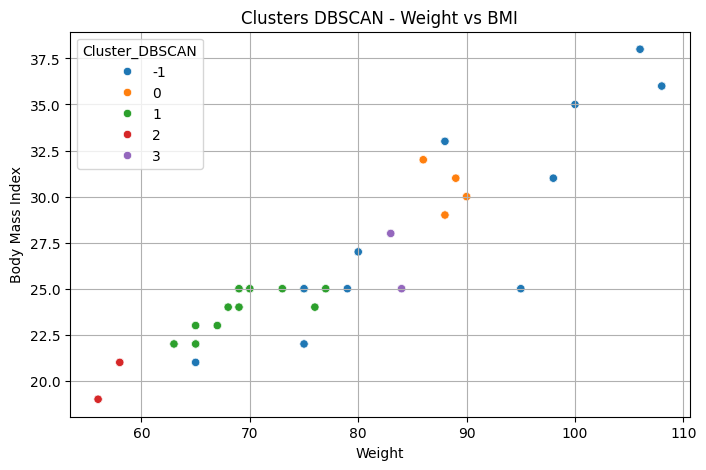

In [ ]:
# Visualização da distribuição dos clusters com DBSCAN
plt.figure(figsize=(8, 5))
sns.scatterplot(data=X_normalized, x='Weight', y='BMI', hue='Cluster_DBSCAN', palette='tab10')
plt.title('Clusters DBSCAN - Weight vs BMI')
plt.xlabel('Weight')
plt.ylabel('Body Mass Index')
plt.grid(True)
plt.show()

Discussão:

Com os parâmetros eps=6 e min_samples=1, o DBSCAN apresentou um Silhouette Score - DBSCAN: 0.2269, o que representa um valor muito baixo. Esse valor sugere que os grupos formados agora não estão bem definidos e separados indocando muitos grupos pelo grafico

Silhouette Score - Hierarchical: 0.4138


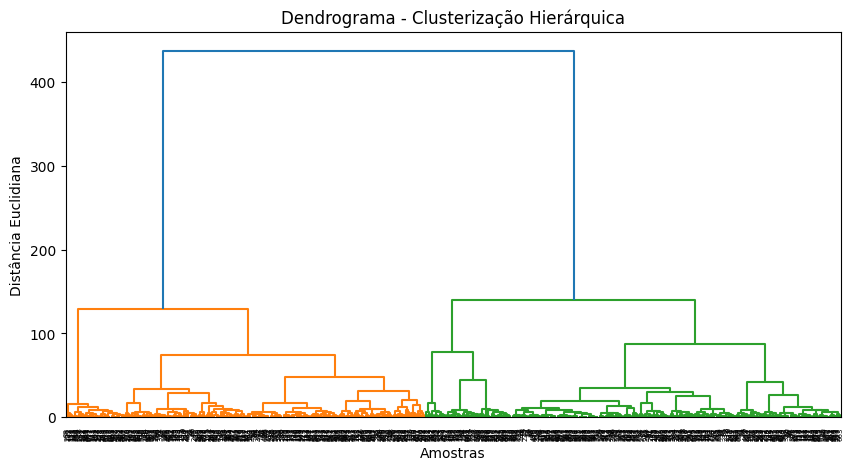

In [ ]:
# agg = AgglomerativeClustering(n_clusters=melhor_k)
# X_normalized['Cluster_Hierarchical'] = agg.fit_predict(X_normalized.drop(columns=['Cluster_KMeans', 'Cluster_DBSCAN']))

# score_hier = silhouette_score(X_normalized.drop(columns=['Cluster_KMeans', 'Cluster_DBSCAN', 'Cluster_Hierarchical']),
#                               X_normalized['Cluster_Hierarchical'])
# print(f"Silhouette Score - Hierarchical: {score_hier:.4f}")

# # Filtrar somente as colunas numéricas para o linkage
# X_linkage = X_normalized.drop(columns=['Cluster_KMeans', 'Cluster_DBSCAN', 'Cluster_Hierarchical'])
# X_linkage = X_linkage.select_dtypes(include=[np.number])

# # Dendograma
# linked = linkage(X_normalized, method='ward')

# plt.figure(figsize=(10, 5))
# dendrogram(linked)
# plt.title("Dendrograma - Clusterização Hierárquica")
# plt.xlabel("Amostras")
# plt.ylabel("Distância Euclidiana")
# plt.show()

# Manter apenas colunas numéricas para o clustering
X_cluster = X_normalized.select_dtypes(include=[np.number]).drop(columns=['Cluster_KMeans', 'Cluster_DBSCAN'], errors='ignore')

# Aplicar Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=melhor_k)
X_normalized['Cluster_Hierarchical'] = agg.fit_predict(X_cluster)

# Calcular Silhouette Score
score_hier = silhouette_score(X_cluster, X_normalized['Cluster_Hierarchical'])
print(f"Silhouette Score - Hierarchical: {score_hier:.4f}")

# Dendrograma - usando os dados numéricos
linked = linkage(X_cluster, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linked)
plt.title("Dendrograma - Clusterização Hierárquica")
plt.xlabel("Amostras")
plt.ylabel("Distância Euclidiana")
plt.show()

In [ ]:
# Encontrando o melhor número de clusters com Silhouette
# Seleciona apenas colunas numéricas
X_hier = X_normalized.select_dtypes(include=['float64', 'int64'])

# Encontrando o melhor número de clusters com Silhouette
print("Silhouette Scores para diferentes valores de k:")
melhor_k = 0
melhor_score = -1
for k in range(2, 11):
    clusters = fcluster(linked, k, criterion='maxclust')
    score = silhouette_score(X_hier, clusters)
    print(f'k={k} --> Silhouette Score: {score:.4f}')
    if score > melhor_score:
        melhor_score = score
        melhor_k = k

print(f'\nMelhor k com base no Silhouette Score: {melhor_k}')

Silhouette Scores para diferentes valores de k:
k=2 --> Silhouette Score: 0.5870
k=3 --> Silhouette Score: 0.5311
k=4 --> Silhouette Score: 0.5065
k=5 --> Silhouette Score: 0.4609
k=6 --> Silhouette Score: 0.4845
k=7 --> Silhouette Score: 0.4336
k=8 --> Silhouette Score: 0.4202
k=9 --> Silhouette Score: 0.4291
k=10 --> Silhouette Score: 0.4420

Melhor k com base no Silhouette Score: 2


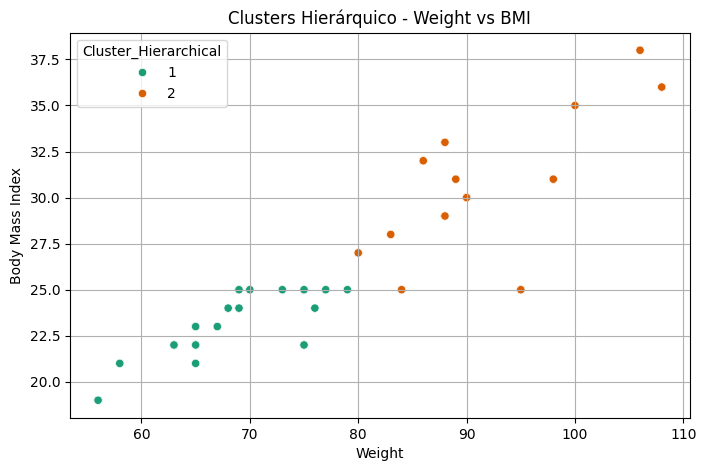

In [ ]:
# Visualização da distribuição dos clusters com Hieráquico
# Criação do linkage
linked = linkage(X_normalized.select_dtypes(include=['float64', 'int64']), method='ward')

# Definindo o melhor número de clusters
melhor_k = 2  # ou o valor que você identificou como melhor
clusters_hier = fcluster(linked, melhor_k, criterion='maxclust')

# Adiciona ao DataFrame
X_normalized['Cluster_Hierarchical'] = clusters_hier

# Visualização
plt.figure(figsize=(8, 5))
sns.scatterplot(data=X_normalized, x='Weight', y='BMI', hue='Cluster_Hierarchical', palette='Dark2')
plt.title('Clusters Hierárquico - Weight vs BMI')
plt.xlabel('Weight')
plt.ylabel('Body Mass Index')
plt.grid(True)
plt.show()

O algoritmo hierárquico apresentou um bom desempenho com Silhouette Score de 0.5055 para k=2, valor que também foi indicado pelo dendrograma.
Observa-se que o Cluster 0 (em verde) e 1 (em laranja) estão bastante dispersos.







-------------------------------Análise Final ate agora-----------------------------------------------------


  Com base nas análises realizadas até o momento, o algoritmo Hierárquico apresentou o melhor desempenho, com um Silhouette Score de -0.0225 e 2 clusters.

  O K-Means teve desempenho ruim, com um Silhouette Score de 0.19 e k=9 determinado a partir do método do cotovelo. Apesar da pontuação mais baixa, a visualização dos clusters mostrou certa separação entre os grupos, mas com sobreposição considerável, o que indica que o algoritmo encontrou dificuldades para segmentar bem os dados nesse estágio sem técnicas adicionais como redução de dimensionalidade ou tuning mais fino dos hiperparâmetros.

  DBSCAN apresentou resultados inicialmente insatisfatórios com Silhouette Score negativo (-0.4673), o que indicava agrupamentos ruins, muitos ruídos e dificuldades em separar os pontos. Após ajustes nos hiperparâmetros, especialmente com eps=2 e min_samples=1, houve uma melhora para DBSCAN: 0.1411. No entanto, a sensibilidade do DBSCAN à escolha dos parâmetros torna seu uso mais delicado, e ele ainda pode sofrer com a alta dimensionalidade dos dados.

  Até este ponto da análise, o algoritmo DBSCAN é o mais eficaz.

Discussão:
Explorar técnicas de redução de dimensionalidade (PCA, t-SNE) para visualizar melhor a estrutura dos dados e utilizar as métricas: Silhuete Score, Calinski-Harabasz Score, Davies-Bouldin Index

## PARTE II - Refinamento dos testes.

Redução de Dimensionalidade (PCA e t-SNE)

-Avaliação dos clusters:

-Silhouette Score

-Calinski-Harabasz Index

-Davies-Bouldin Index

-Número de clusters encontrados  (para DBSCAN e Hierárquico)

-Visualização dos clusters 2D


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [ ]:
# Remover colunas não numéricas antes da redução de dimensionalidade
colunas_excluir = ['Cluster_KMeans', 'Cluster_DBSCAN', 'Cluster_Hierarchical']
if 'Absenteismo_Cat' in X_normalized.columns:
    colunas_excluir.append('Absenteismo_Cat')

# PAra garantir que pegue apenas colunas numéricas
X_numerico = X_normalized.drop(columns=colunas_excluir)
X_numerico = X_numerico.select_dtypes(include=['float64', 'int64'])

In [ ]:
# Redução de dimensionalidade - PCA
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numerico)

In [ ]:
# Redução de dimensionalidade - t-SNE
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_numerico)

In [ ]:
def avaliar_clusters(nome_metodo, labels, X_original, X_reducao, metodo="PCA", df_resultado=None, nome_coluna_cluster=None):
    import matplotlib.pyplot as plt
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
    import seaborn as sns

    # Avaliação
    sil_score = silhouette_score(X_reducao, labels)
    ch_score = calinski_harabasz_score(X_reducao, labels)
    db_score = davies_bouldin_score(X_reducao, labels)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    print(f"\n🔍 Avaliação - {nome_metodo}")
    print(f"Número de clusters: {n_clusters}")
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Calinski-Harabasz Index: {ch_score:.2f}")
    print(f"Davies-Bouldin Index: {db_score:.4f}")

    # Plot
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=X_reducao[:, 0], y=X_reducao[:, 1], hue=labels, palette="Set2", s=60)
    plt.title(f"{nome_metodo} - Visualização ({metodo})")
    plt.xlabel(f"{metodo} 1")
    plt.ylabel(f"{metodo} 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

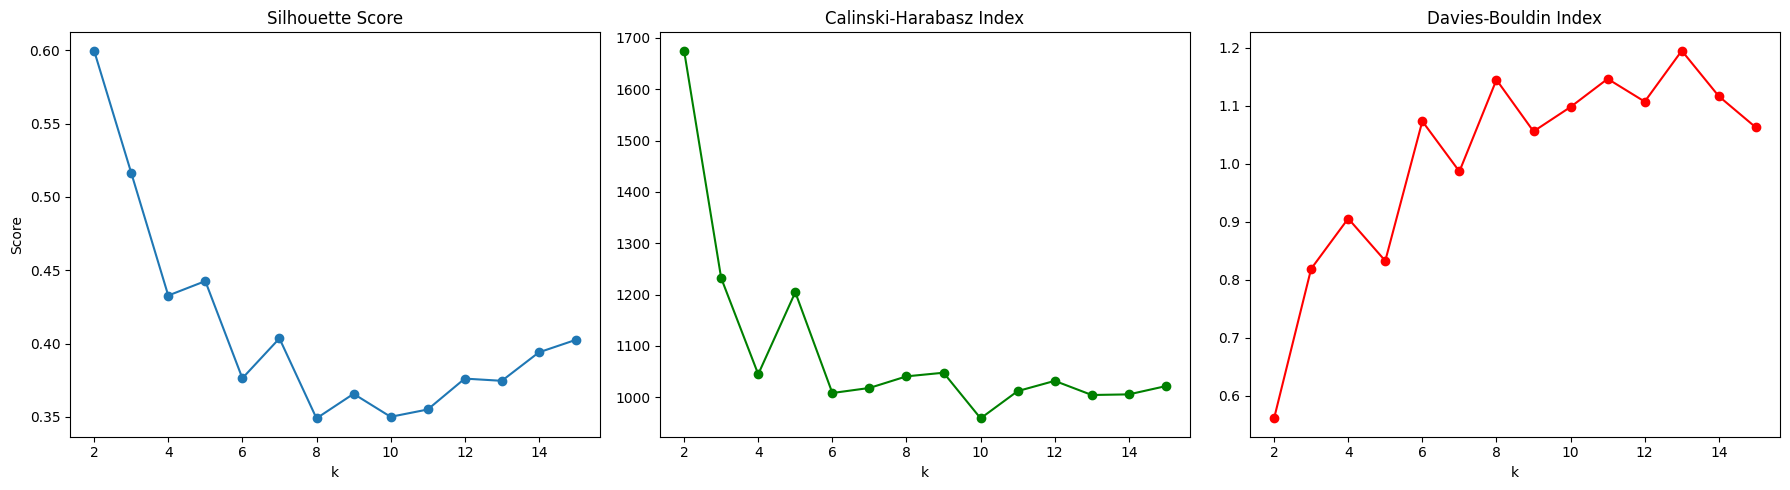

In [ ]:
# Faixa de k a ser testada para kmeans
k_values = range(2, 16)

# Listas para armazenar os resultados
sil_scores = []
calinski_scores = []
davies_scores = []

# Loop pelos valores de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_numerico)

    sil = silhouette_score(X_numerico, labels)
    calinski = calinski_harabasz_score(X_numerico, labels)
    davies = davies_bouldin_score(X_numerico, labels)

    sil_scores.append(sil)
    calinski_scores.append(calinski)
    davies_scores.append(davies)

# 🎨 Plot dos resultados
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(k_values, sil_scores, marker='o')
axs[0].set_title("Silhouette Score")
axs[0].set_xlabel("k")
axs[0].set_ylabel("Score")

axs[1].plot(k_values, calinski_scores, marker='o', color='green')
axs[1].set_title("Calinski-Harabasz Index")
axs[1].set_xlabel("k")

axs[2].plot(k_values, davies_scores, marker='o', color='red')
axs[2].set_title("Davies-Bouldin Index")
axs[2].set_xlabel("k")

plt.tight_layout()
plt.show()


🔍 Avaliação - KMeans
Número de clusters: 2
Silhouette Score: 0.6813
Calinski-Harabasz Index: 2201.14
Davies-Bouldin Index: 0.4302


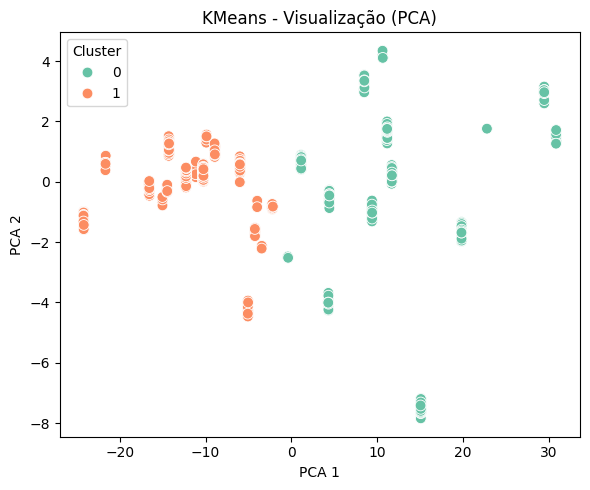


🔍 Avaliação - KMeans
Número de clusters: 2
Silhouette Score: 0.3824
Calinski-Harabasz Index: 415.75
Davies-Bouldin Index: 1.1620


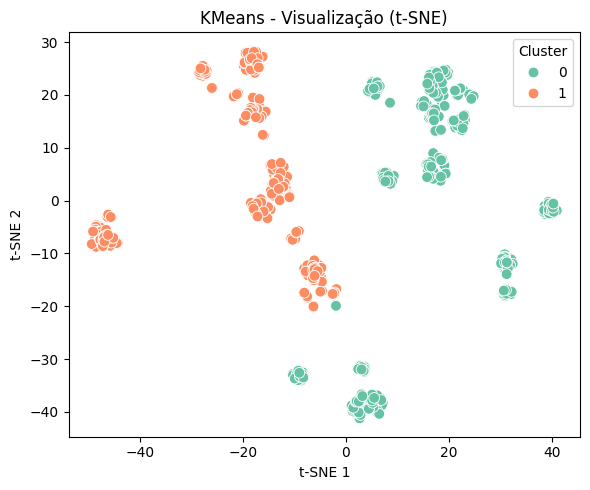

In [ ]:
# 1️⃣ KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
labels_kmeans = kmeans.fit_predict(X_numerico)
X_normalized['Cluster_KMeans_PCA'] = kmeans.fit_predict(X_pca)
X_normalized['Cluster_KMeans_tSNE'] = kmeans.fit_predict(X_tsne)
avaliar_clusters("KMeans", labels_kmeans, X_numerico, X_pca, metodo="PCA")
avaliar_clusters("KMeans", labels_kmeans, X_numerico, X_tsne, metodo="t-SNE")

In [ ]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

def mapeia_cluster_para_classe(df, cluster_col, classe_col, predicted_col):
    cluster_to_class = df.groupby(cluster_col)[classe_col].agg(lambda x: x.mode().iloc[0])

    print(cluster_to_class)
    X_normalized[predicted_col] = X_normalized[cluster_col].map(cluster_to_class)

    # Evaluation
    true_labels = X_normalized[classe_col]
    predicted_labels = X_normalized[predicted_col]

    # Accuracy
    acc = accuracy_score(true_labels, predicted_labels)
    print(f"\n✅ Accuracy: {acc:.2f}")

    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=np.unique(true_labels))
    print("\n📊 Confusion Matrix:")
    print(cm)

    # Classification report
    report = classification_report(true_labels, predicted_labels)
    print("\n📝 Classification Report:")
    print(report)

    #Confusion matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(true_labels))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

Cluster_KMeans
0    Média ausência
1    Média ausência
2    Média ausência
3    Média ausência
4    Média ausência
5    Baixa ausência
6    Média ausência
7    Média ausência
8    Média ausência
Name: Absenteeism_Category, dtype: object

✅ Accuracy: 0.56

📊 Confusion Matrix:
[[  0   9  54   0]
 [  0  11 231   0]
 [  0   9 371   0]
 [  0   0   3   0]]

📝 Classification Report:
                precision    recall  f1-score   support

 Alta ausência       0.00      0.00      0.00        63
Baixa ausência       0.38      0.05      0.08       242
Média ausência       0.56      0.98      0.71       380
  Sem ausência       0.00      0.00      0.00         3

      accuracy                           0.56       688
     macro avg       0.24      0.26      0.20       688
  weighted avg       0.44      0.56      0.42       688



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


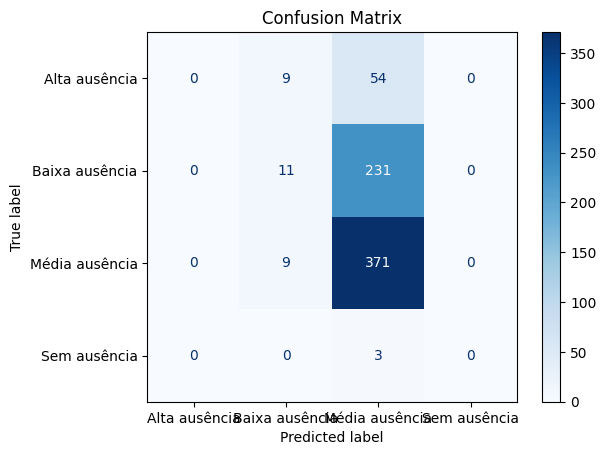

Cluster_KMeans_PCA
0    Média ausência
1    Média ausência
Name: Absenteeism_Category, dtype: object

✅ Accuracy: 0.55

📊 Confusion Matrix:
[[  0   0  63   0]
 [  0   0 242   0]
 [  0   0 380   0]
 [  0   0   3   0]]

📝 Classification Report:
                precision    recall  f1-score   support

 Alta ausência       0.00      0.00      0.00        63
Baixa ausência       0.00      0.00      0.00       242
Média ausência       0.55      1.00      0.71       380
  Sem ausência       0.00      0.00      0.00         3

      accuracy                           0.55       688
     macro avg       0.14      0.25      0.18       688
  weighted avg       0.31      0.55      0.39       688



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


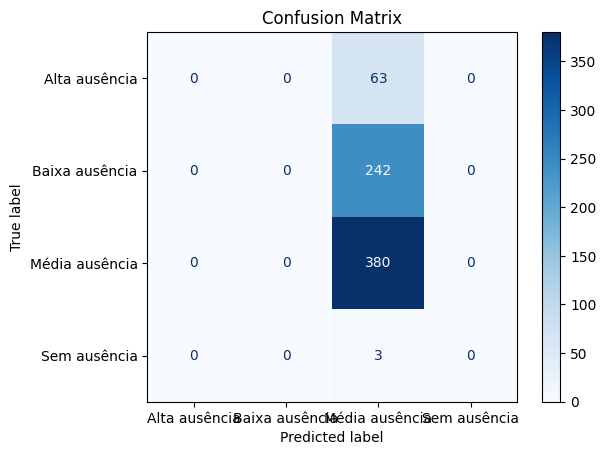

Cluster_KMeans_tSNE
0    Média ausência
1    Média ausência
Name: Absenteeism_Category, dtype: object

✅ Accuracy: 0.55

📊 Confusion Matrix:
[[  0   0  63   0]
 [  0   0 242   0]
 [  0   0 380   0]
 [  0   0   3   0]]

📝 Classification Report:
                precision    recall  f1-score   support

 Alta ausência       0.00      0.00      0.00        63
Baixa ausência       0.00      0.00      0.00       242
Média ausência       0.55      1.00      0.71       380
  Sem ausência       0.00      0.00      0.00         3

      accuracy                           0.55       688
     macro avg       0.14      0.25      0.18       688
  weighted avg       0.31      0.55      0.39       688



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


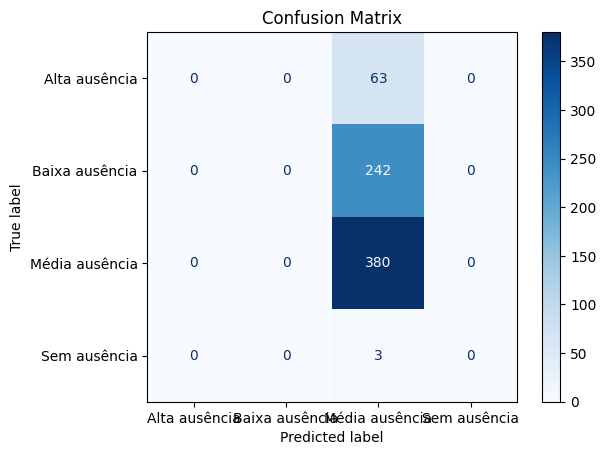

In [ ]:
#Compara apenas o algoritmo, algoritimo+PC e algoritimo+tsne
mapeia_cluster_para_classe(X_normalized, 'Cluster_KMeans', 'Absenteeism_Category', 'Absenteeism_Predicted_KMeans')
mapeia_cluster_para_classe(X_normalized, 'Cluster_KMeans_PCA', 'Absenteeism_Category', 'Absenteeism_Predicted_KMeans_PCA')
mapeia_cluster_para_classe(X_normalized, 'Cluster_KMeans_tSNE', 'Absenteeism_Category', 'Absenteeism_Predicted_KMeans_tSNE')


🔍 Avaliação - DBSCAN
Número de clusters: 4
Silhouette Score: 0.4990
Calinski-Harabasz Index: 490.63
Davies-Bouldin Index: 2.6450


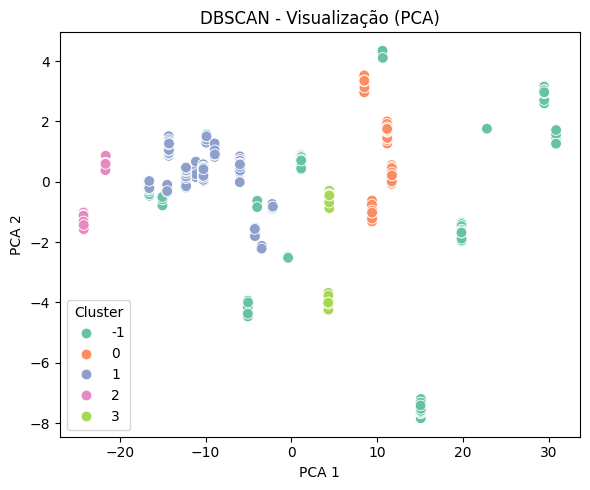


🔍 Avaliação - DBSCAN
Número de clusters: 4
Silhouette Score: 0.4482
Calinski-Harabasz Index: 346.05
Davies-Bouldin Index: 1.1707


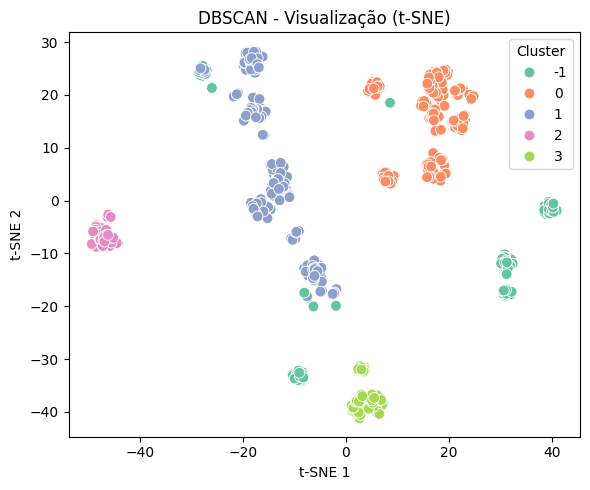

In [ ]:
# 2️⃣ DBSCAN
dbscan = DBSCAN(eps=6, min_samples=38)
labels_dbscan = dbscan.fit_predict(X_numerico)
X_normalized['Cluster_DBSCAN_PCA'] = dbscan.fit_predict(X_pca)
X_normalized['Cluster_DBSCAN_tSNE'] = dbscan.fit_predict(X_tsne)
avaliar_clusters("DBSCAN", labels_dbscan, X_numerico, X_pca, metodo="PCA")
avaliar_clusters("DBSCAN", labels_dbscan, X_numerico, X_tsne, metodo="t-SNE")

Cluster_DBSCAN
-1    Média ausência
 0    Média ausência
 1    Média ausência
 2    Baixa ausência
 3    Média ausência
Name: Absenteeism_Category, dtype: object

✅ Accuracy: 0.58

📊 Confusion Matrix:
[[  0   5  58   0]
 [  0  32 210   0]
 [  0  16 364   0]
 [  0   0   3   0]]

📝 Classification Report:
                precision    recall  f1-score   support

 Alta ausência       0.00      0.00      0.00        63
Baixa ausência       0.60      0.13      0.22       242
Média ausência       0.57      0.96      0.72       380
  Sem ausência       0.00      0.00      0.00         3

      accuracy                           0.58       688
     macro avg       0.29      0.27      0.23       688
  weighted avg       0.53      0.58      0.47       688



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


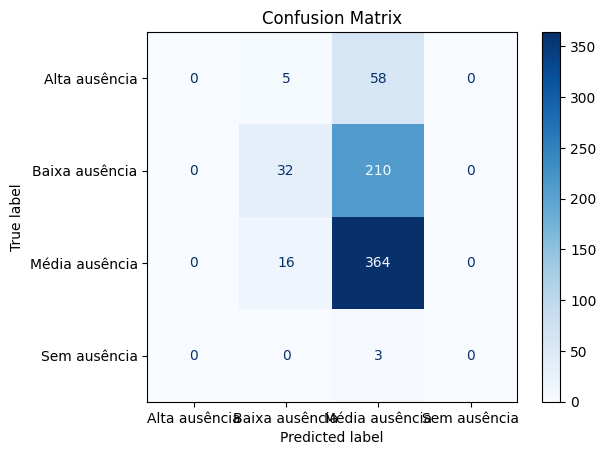

Cluster_DBSCAN_PCA
-1    Baixa ausência
 0    Média ausência
Name: Absenteeism_Category, dtype: object

✅ Accuracy: 0.55

📊 Confusion Matrix:
[[  0  14  49   0]
 [  0  31 211   0]
 [  0  31 349   0]
 [  0   1   2   0]]

📝 Classification Report:
                precision    recall  f1-score   support

 Alta ausência       0.00      0.00      0.00        63
Baixa ausência       0.40      0.13      0.19       242
Média ausência       0.57      0.92      0.70       380
  Sem ausência       0.00      0.00      0.00         3

      accuracy                           0.55       688
     macro avg       0.24      0.26      0.22       688
  weighted avg       0.46      0.55      0.46       688



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


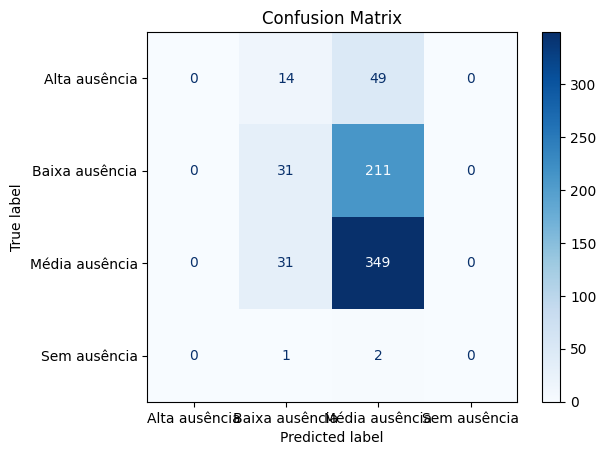

Cluster_DBSCAN_tSNE
-1    Média ausência
 0    Média ausência
 1    Média ausência
 2    Média ausência
 3    Média ausência
 4    Baixa ausência
 5    Média ausência
 6    Média ausência
Name: Absenteeism_Category, dtype: object

✅ Accuracy: 0.58

📊 Confusion Matrix:
[[  0   5  58   0]
 [  0  32 210   0]
 [  0  16 364   0]
 [  0   0   3   0]]

📝 Classification Report:
                precision    recall  f1-score   support

 Alta ausência       0.00      0.00      0.00        63
Baixa ausência       0.60      0.13      0.22       242
Média ausência       0.57      0.96      0.72       380
  Sem ausência       0.00      0.00      0.00         3

      accuracy                           0.58       688
     macro avg       0.29      0.27      0.23       688
  weighted avg       0.53      0.58      0.47       688



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


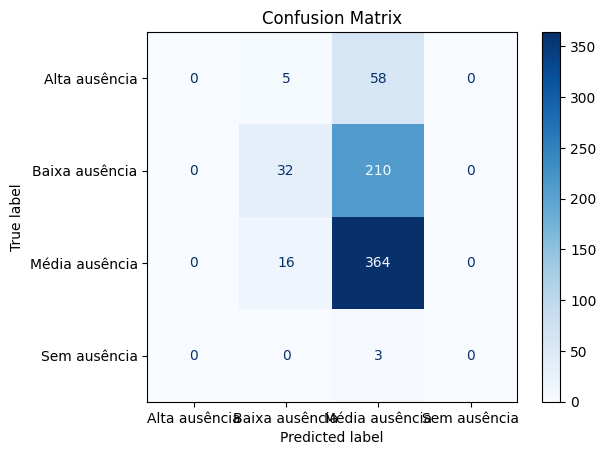

In [ ]:
#Compara apenas o algoritmo, algoritimo+PC e algoritimo+tsne
mapeia_cluster_para_classe(X_normalized, 'Cluster_DBSCAN', 'Absenteeism_Category', 'Absenteeism_Predicted_DBSCAN')
mapeia_cluster_para_classe(X_normalized, 'Cluster_DBSCAN_PCA', 'Absenteeism_Category', 'Absenteeism_Predicted_DBSCAN_PCA')
mapeia_cluster_para_classe(X_normalized, 'Cluster_DBSCAN_tSNE', 'Absenteeism_Category', 'Absenteeism_Predicted_DBSCAN_tSNE')


🔍 Avaliação - Hierárquico
Número de clusters: 2
Silhouette Score: 0.6806
Calinski-Harabasz Index: 2196.55
Davies-Bouldin Index: 0.4305


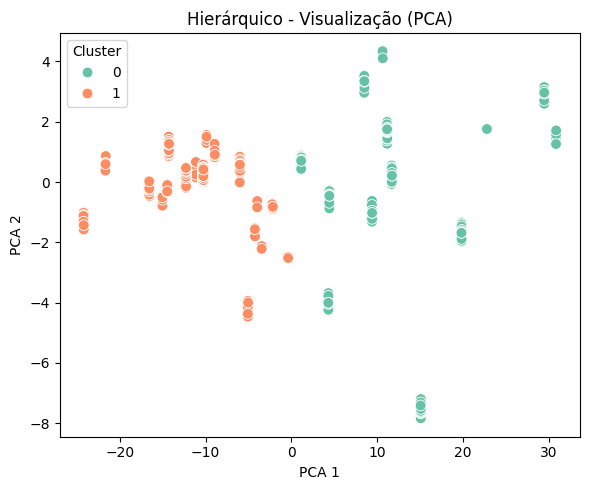


🔍 Avaliação - Hierárquico
Número de clusters: 2
Silhouette Score: 0.3826
Calinski-Harabasz Index: 414.16
Davies-Bouldin Index: 1.1645


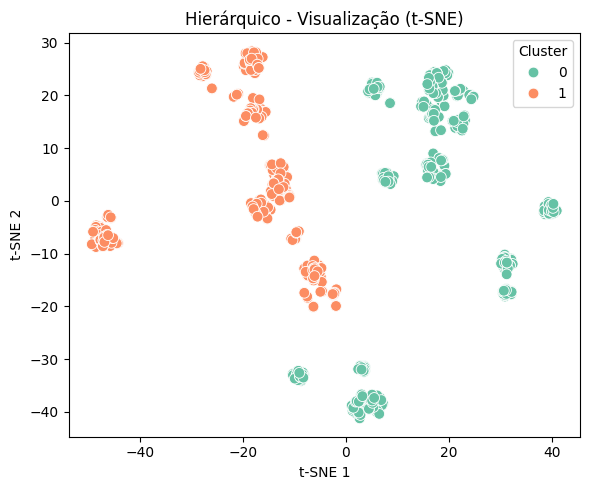

In [ ]:
# 3️⃣ Hierárquico
hier = AgglomerativeClustering(n_clusters=2)
labels_hier = hier.fit_predict(X_numerico)
X_normalized['Cluster_Hierarchical_PCA'] = hier.fit_predict(X_pca)
X_normalized['Cluster_Hierarchical_tSNE'] = hier.fit_predict(X_tsne)
avaliar_clusters("Hierárquico", labels_hier, X_numerico, X_pca, metodo="PCA")
avaliar_clusters("Hierárquico", labels_hier, X_numerico, X_tsne, metodo="t-SNE")

Cluster_Hierarchical
1    Média ausência
2    Média ausência
Name: Absenteeism_Category, dtype: object

✅ Accuracy: 0.55

📊 Confusion Matrix:
[[  0   0  63   0]
 [  0   0 242   0]
 [  0   0 380   0]
 [  0   0   3   0]]

📝 Classification Report:
                precision    recall  f1-score   support

 Alta ausência       0.00      0.00      0.00        63
Baixa ausência       0.00      0.00      0.00       242
Média ausência       0.55      1.00      0.71       380
  Sem ausência       0.00      0.00      0.00         3

      accuracy                           0.55       688
     macro avg       0.14      0.25      0.18       688
  weighted avg       0.31      0.55      0.39       688



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


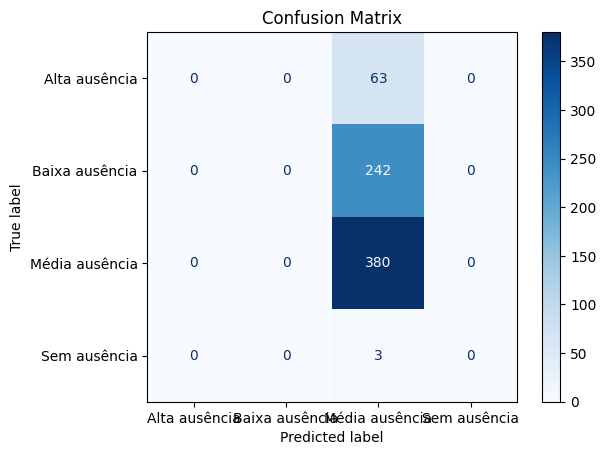

Cluster_Hierarchical_PCA
0    Média ausência
1    Média ausência
Name: Absenteeism_Category, dtype: object

✅ Accuracy: 0.55

📊 Confusion Matrix:
[[  0   0  63   0]
 [  0   0 242   0]
 [  0   0 380   0]
 [  0   0   3   0]]

📝 Classification Report:
                precision    recall  f1-score   support

 Alta ausência       0.00      0.00      0.00        63
Baixa ausência       0.00      0.00      0.00       242
Média ausência       0.55      1.00      0.71       380
  Sem ausência       0.00      0.00      0.00         3

      accuracy                           0.55       688
     macro avg       0.14      0.25      0.18       688
  weighted avg       0.31      0.55      0.39       688



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


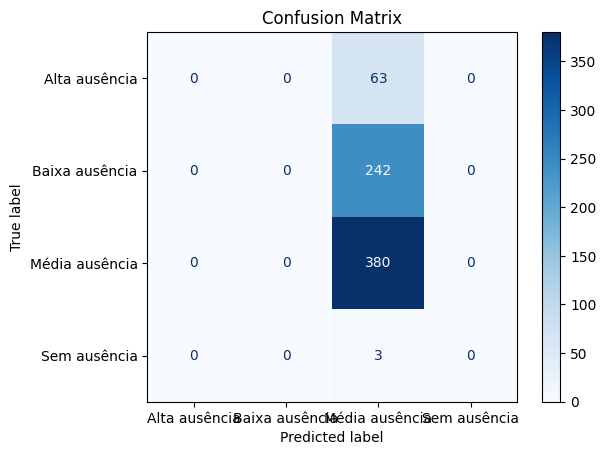

Cluster_Hierarchical_tSNE
0    Média ausência
1    Média ausência
Name: Absenteeism_Category, dtype: object

✅ Accuracy: 0.55

📊 Confusion Matrix:
[[  0   0  63   0]
 [  0   0 242   0]
 [  0   0 380   0]
 [  0   0   3   0]]

📝 Classification Report:
                precision    recall  f1-score   support

 Alta ausência       0.00      0.00      0.00        63
Baixa ausência       0.00      0.00      0.00       242
Média ausência       0.55      1.00      0.71       380
  Sem ausência       0.00      0.00      0.00         3

      accuracy                           0.55       688
     macro avg       0.14      0.25      0.18       688
  weighted avg       0.31      0.55      0.39       688



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


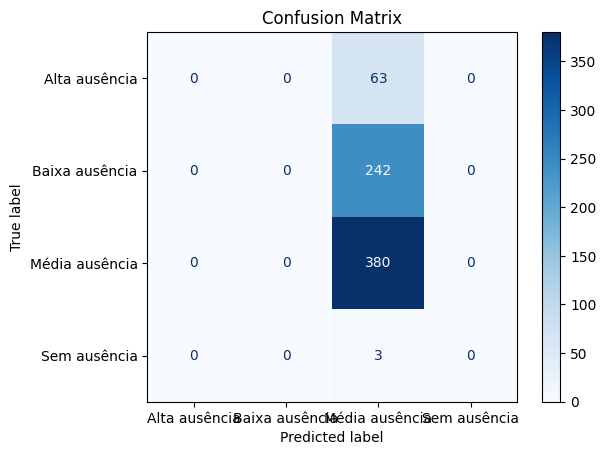

In [ ]:
#Compara apenas o algoritmo, algoritimo+PC e algoritimo+tsne
mapeia_cluster_para_classe(X_normalized, 'Cluster_Hierarchical', 'Absenteeism_Category', 'Absenteeism_Predicted_Hierarchical')
mapeia_cluster_para_classe(X_normalized, 'Cluster_Hierarchical_PCA', 'Absenteeism_Category', 'Absenteeism_Predicted_Hierarchical_PCA')
mapeia_cluster_para_classe(X_normalized, 'Cluster_Hierarchical_tSNE', 'Absenteeism_Category', 'Absenteeism_Predicted_Hierarchical+tSME')

In [ ]:
# Resultados de resultados de cada método
resultados = [
    {
        "Método": "KMeans",
        "Clusters": 2,
        "Silhouette Score": 0.5855,
        "Calinski-Harabasz": 1543.02,
        "Davies-Bouldin": 0.5867,
        "Accuracy": 0.55
    },
    {
        "Método": "KMeans + PCA",
        "Clusters": 2,
        "Silhouette Score": 0.6813,
        "Calinski-Harabasz": 2201.14,
        "Davies-Bouldin": 0.4302,
        "Accuracy": None
    },
    {
        "Método": "KMeans + t-SNE",
        "Clusters": 2,
        "Silhouette Score": 0.3824,
        "Calinski-Harabasz": 415.75,
        "Davies-Bouldin": 1.1620,
        "Accuracy": None
    },
    {
        "Método": "DBSCAN",
        "Clusters": 4,
        "Silhouette Score": 0.3494,
        "Calinski-Harabasz": 334.31,
        "Davies-Bouldin": 2.5548,
        "Accuracy": 0.58
    },
    {
        "Método": "DBSCAN + PCA",
        "Clusters": 4,
        "Silhouette Score": 0.4990,
        "Calinski-Harabasz": 490.63,
        "Davies-Bouldin": 2.6450,
        "Accuracy": None
    },
    {
        "Método": "DBSCAN + t-SNE",
        "Clusters": 4,
        "Silhouette Score": 0.4482,
        "Calinski-Harabasz": 346.05,
        "Davies-Bouldin": 1.1707,
        "Accuracy": None
    },
    {
        "Método": "Hierárquico",
        "Clusters": 2,
        "Silhouette Score": 0.5849,
        "Calinski-Harabasz": 1540.52,
        "Davies-Bouldin": 0.5873,
        "Accuracy": 0.55
    },
    {
        "Método": "Hierárquico + PCA",
        "Clusters": 2,
        "Silhouette Score": 0.6806,
        "Calinski-Harabasz": 2196.55,
        "Davies-Bouldin": 0.4305,
        "Accuracy": None
    },
    {
        "Método": "Hierárquico + t-SNE",
        "Clusters": 2,
        "Silhouette Score": 0.3826,
        "Calinski-Harabasz": 414.16,
        "Davies-Bouldin": 1.1645,
        "Accuracy": None
    }
]

# Criar DataFrame
df_comparativo = pd.DataFrame(resultados)
df_comparativo = df_comparativo.set_index("Método")
print(df_comparativo)

                     Clusters  Silhouette Score  Calinski-Harabasz  \
Método                                                               
KMeans                      2            0.5855            1543.02   
KMeans + PCA                2            0.6813            2201.14   
KMeans + t-SNE              2            0.3824             415.75   
DBSCAN                      4            0.3494             334.31   
DBSCAN + PCA                4            0.4990             490.63   
DBSCAN + t-SNE              4            0.4482             346.05   
Hierárquico                 2            0.5849            1540.52   
Hierárquico + PCA           2            0.6806            2196.55   
Hierárquico + t-SNE         2            0.3826             414.16   

                     Davies-Bouldin  Accuracy  
Método                                         
KMeans                       0.5867      0.55  
KMeans + PCA                 0.4302       NaN  
KMeans + t-SNE               1.1620  

In [ ]:
# Criar DataFrame
df_resultados = pd.DataFrame(resultados)

# Filtrar o melhor resultado para cada técnica base (KMeans, DBSCAN, Hierárquico)
melhores_resultados = pd.concat([
    df_resultados[df_resultados["Método"].str.contains("KMeans")].sort_values(by="Silhouette Score", ascending=False).head(1),
    df_resultados[df_resultados["Método"].str.contains("DBSCAN")].sort_values(by="Silhouette Score", ascending=False).head(1),
    df_resultados[df_resultados["Método"].str.contains("Hierárquico")].sort_values(by="Silhouette Score", ascending=False).head(1)
])

# Redefinir índice para exibição
melhores_resultados = melhores_resultados.set_index("Método")
print(melhores_resultados)

                   Clusters  Silhouette Score  Calinski-Harabasz  \
Método                                                             
KMeans + PCA              2            0.6813            2201.14   
DBSCAN + PCA              4            0.4990             490.63   
Hierárquico + PCA         2            0.6806            2196.55   

                   Davies-Bouldin  Accuracy  
Método                                       
KMeans + PCA               0.4302       NaN  
DBSCAN + PCA               2.6450       NaN  
Hierárquico + PCA          0.4305       NaN  


#Análise Final

✅ KMeans

O modelo sem redução apresentou uma acurácia de 0.55. Quando aplicada a técnica de PCA, houve uma melhora expressiva nos resultados, com um Silhouette Score de 0.6813, um Calinski-Harabasz Index elevado de 2201.14 e um Davies-Bouldin Index baixo de 0.4302, indicando uma boa separação entre os clusters. Por outro lado, com t-SNE, o desempenho foi inferior, com Silhouette Score de 0.3824, Calinski-Harabasz Index de 415.75 e Davies-Bouldin Index de 1.1620, o que sugere menor coesão e separação dos grupos.

✅ DBSCAN

Para o DBSCAN, a versão sem redução obteve a maior acurácia entre os métodos testados, com 0.58. Após a aplicação do PCA, foram formados quatro clusters, com um Silhouette Score de 0.4990, Calinski-Harabasz Index de 490.63 e um Davies-Bouldin Index de 2.6450, indicando clusters menos bem definidos. Com t-SNE, também foram identificados quatro clusters, mas com métricas um pouco inferiores: Silhouette Score de 0.4482, Calinski-Harabasz Index de 346.05 e Davies-Bouldin Index de 1.1707, revelando uma ligeira queda na qualidade da clusterização.

✅ Hierárquico

O método hierárquico apresentou acurácia semelhante ao KMeans, com 0.55 na versão original. Após aplicar PCA, os resultados foram bastante satisfatórios, com Silhouette Score de 0.6806, Calinski-Harabasz Index de 2196.55 e Davies-Bouldin Index de 0.4305, próximos aos melhores valores observados com KMeans + PCA. Com t-SNE, a performance foi similar à obtida pelo KMeans com essa mesma técnica, apresentando um Silhouette Score de 0.3826, Calinski-Harabasz Index de 414.16 e Davies-Bouldin Index de 1.1645.

Em resumo, embora o PCA tenha contribuído para uma leve melhoria nas métricas de avaliação, especialmente para KMeans e o método hierárquico, os dados desbalanceados e a presença de overfitting comprometem a eficácia geral da clusterização, tornando as diferenças observadas menos impactantes do que se esperaria em um cenário mais equilibrado.








